In [20]:
# import required packages
import cv2
import os
import pandas as pd
import random
import numpy as np
import imghdr
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from keras import layers, models, regularizers, optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, Adamax
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model


In [21]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

In [22]:
# Paths to the training and testing directories.
train_dir = 'data/train'
test_dir = 'data/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<Axes: >

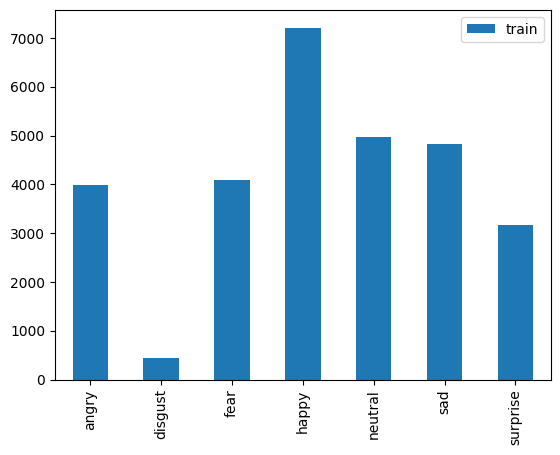

In [23]:
train_count.transpose().plot(kind='bar')

<Axes: >

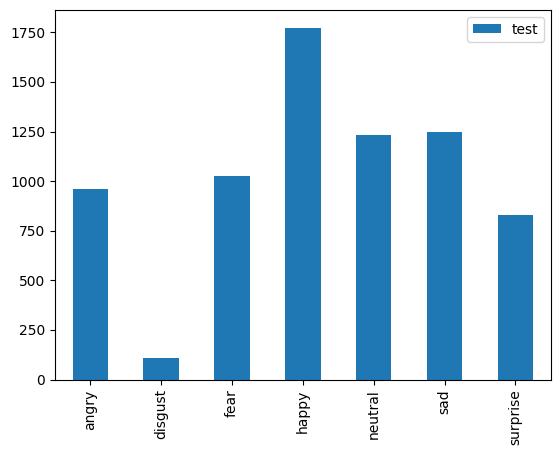

In [24]:
test_count.transpose().plot(kind='bar')

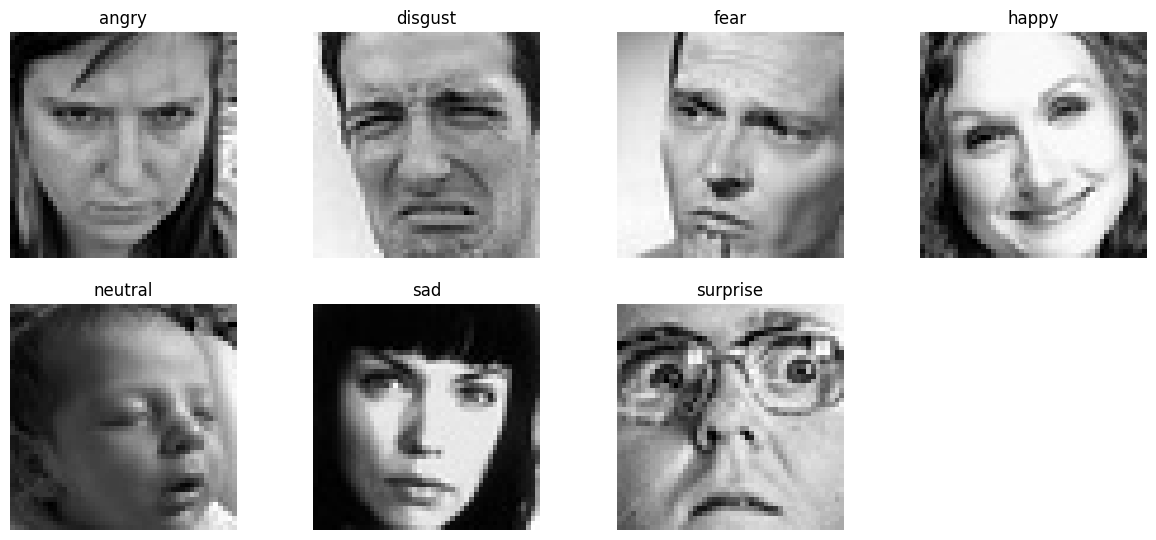

In [25]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[12])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.grid()
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [26]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

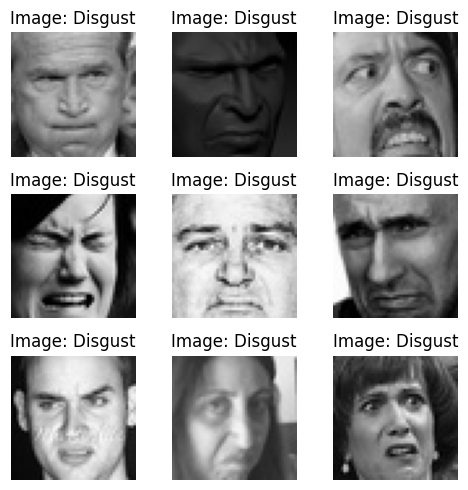

In [27]:
# Placeholder for the directory path
disgust_directory_path = 'data/train/disgust'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

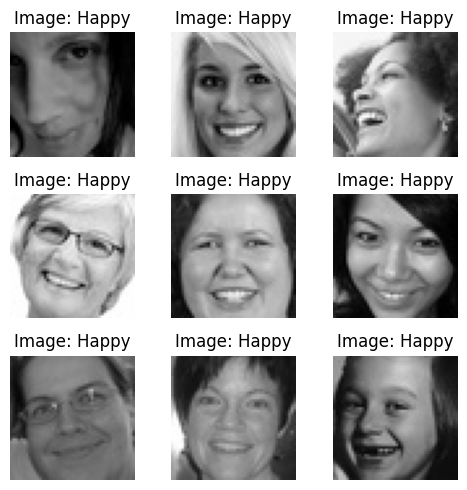

In [28]:
# Placeholder for the directory path
happy_directory_path = 'data/train/happy'  # Replace with your directory path
plot_images_from_directory(happy_directory_path, class_name = 'Happy')

In [29]:

image_path = 'data/train/angry/Training_10120469.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


In [30]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)
data_generator = ImageDataGenerator(rescale=1./255)

In [31]:
# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        'data/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.


In [32]:
# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        'data/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [33]:
test_generator = validation_generator

In [34]:
# create model structure
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

# emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])


emotion_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001, weight_decay=1e-6),
    metrics=['accuracy']
)



In [35]:
emotion_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                 

In [36]:
# Train the neural network/model
emotion_model_info = emotion_model.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

Epoch 1/50
448/448 [==============================] - 98s 217ms/step - loss: 1.7907 - accuracy: 0.2642 - val_loss: 1.6874 - val_accuracy: 0.3597
Epoch 2/50
448/448 [==============================] - 96s 214ms/step - loss: 1.6203 - accuracy: 0.3708 - val_loss: 1.5449 - val_accuracy: 0.4121
Epoch 3/50
448/448 [==============================] - 97s 216ms/step - loss: 1.5335 - accuracy: 0.4095 - val_loss: 1.4672 - val_accuracy: 0.4456
Epoch 4/50
448/448 [==============================] - 97s 216ms/step - loss: 1.4694 - accuracy: 0.4340 - val_loss: 1.4071 - val_accuracy: 0.4661
Epoch 5/50
448/448 [==============================] - 96s 215ms/step - loss: 1.4060 - accuracy: 0.4623 - val_loss: 1.3618 - val_accuracy: 0.4820
Epoch 6/50
448/448 [==============================] - 97s 215ms/step - loss: 1.3535 - accuracy: 0.4849 - val_loss: 1.3217 - val_accuracy: 0.4996
Epoch 7/50
448/448 [==============================] - 96s 214ms/step - loss: 1.3093 - accuracy: 0.5043 - val_loss: 1.2784 - val_ac

In [37]:
def plot_training_history(emotion_model_info):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = emotion_model_info.history['accuracy']
    val_acc = emotion_model_info.history['val_accuracy']
    loss = emotion_model_info.history['loss']
    val_loss = emotion_model_info.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

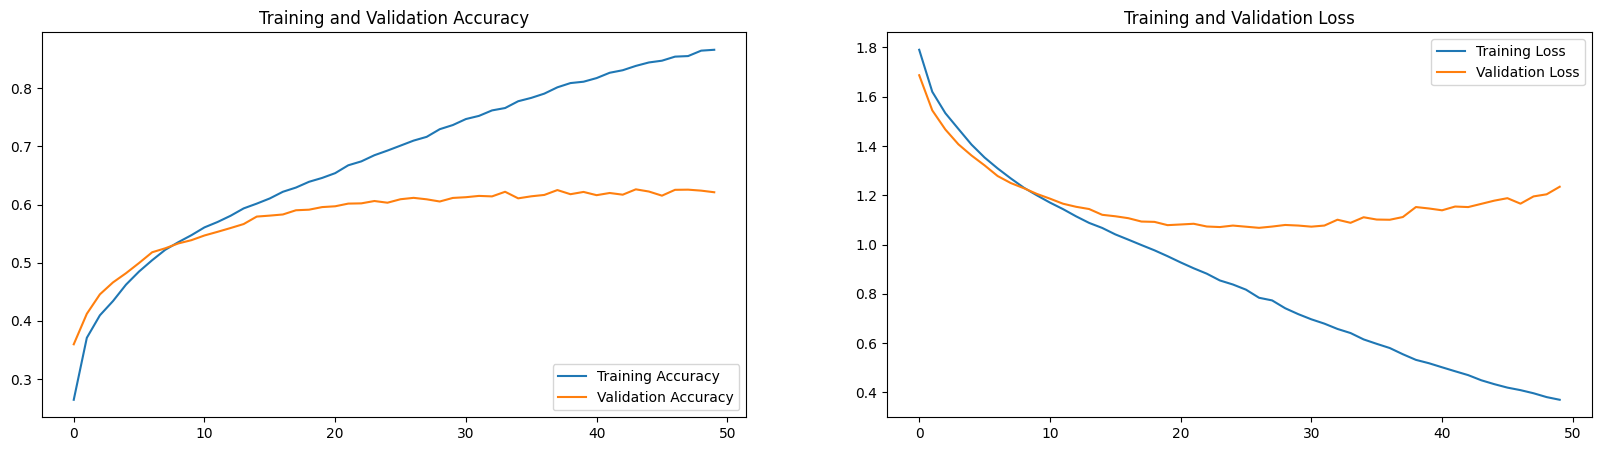

In [38]:
plot_training_history(emotion_model_info)

In [39]:
# train_loss, train_accu = emotion_model_info.evaluate(train_generator)
# test_loss, test_accu = emotion_model_info.evaluate(test_generator)
# print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))
# Evaluate the model on training and test data
train_loss, train_accu = emotion_model.evaluate(train_generator, steps=len(train_generator))
test_loss, test_accu = emotion_model.evaluate(test_generator, steps=len(test_generator))

# Print the results
print("Final train accuracy = {:.2f}%, validation accuracy = {:.2f}%".format(train_accu * 100, test_accu * 100))


113/113 [==============================] - 5s 42ms/step - loss: 1.2351 - accuracy: 0.6213
Final train accuracy = 97.81%, validation accuracy = 62.13%


In [40]:
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import plot_model

113/113 [==============================] - 5s 43ms/step


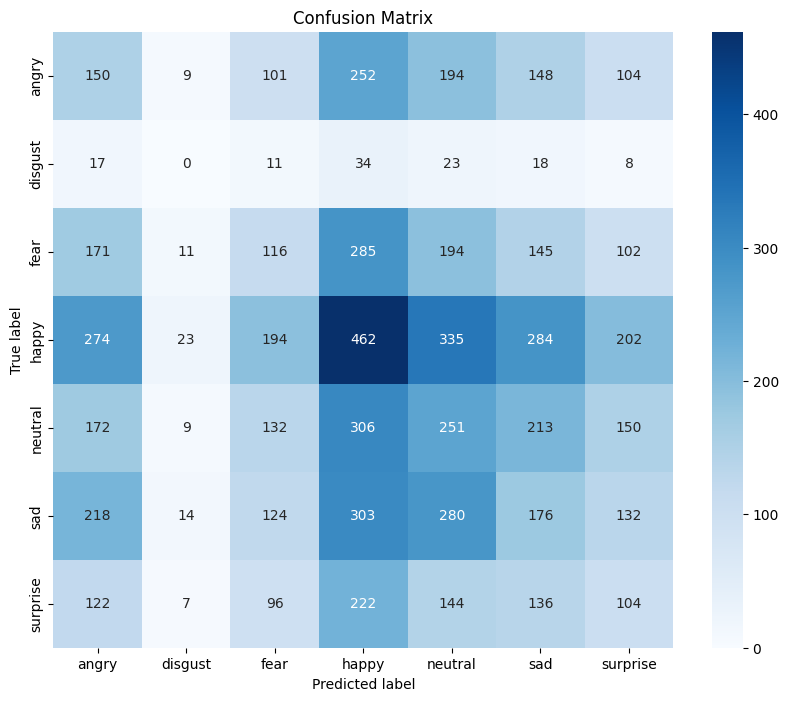

In [41]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(emotion_model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [42]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=1)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.16      0.14       958
     disgust       0.00      0.00      1.00       111
        fear       0.15      0.11      0.13      1024
       happy       0.25      0.26      0.25      1774
     neutral       0.18      0.20      0.19      1233
         sad       0.16      0.14      0.15      1247
    surprise       0.13      0.13      0.13       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.28      7178
weighted avg       0.17      0.18      0.19      7178



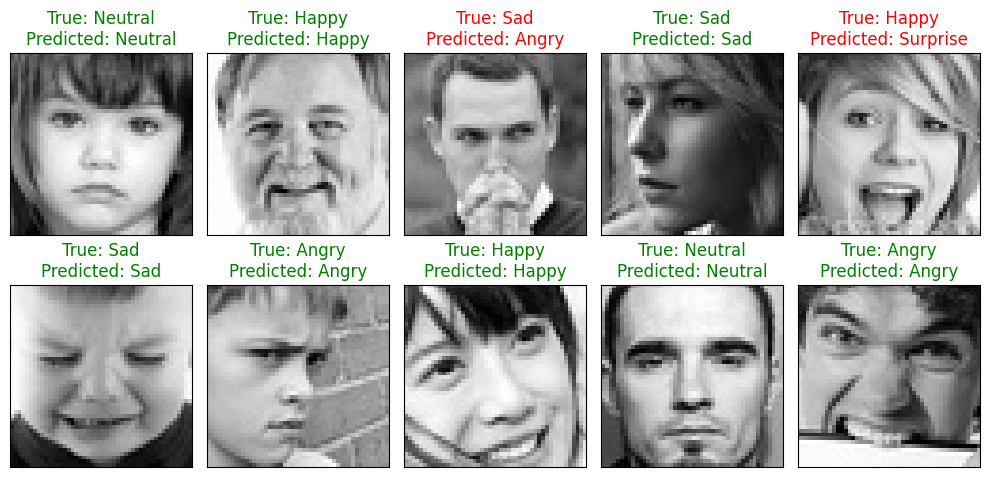

In [50]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(emotion_model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [44]:
# save model structure in jason file
model_json = emotion_model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

In [45]:
# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model.h5')